In [2]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [49]:
#OPTION A: Try to make all predictors work
van_data_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num"))

cleveland_data_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num")) 

hungary_data_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num"))

switzerland_data_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num"))

#Next, we can merge these, as they all have the same predictors. More data can ensure our analysis is more accurate.
#Each factor must be numeric for the purpose of our analysis, and we have to remove any N/A values.
heart_disease_data <- rbind(van_data_csv,cleveland_data_csv,hungary_data_csv, switzerland_data_csv) %>%
                select(-sex) %>%
                select(-num) %>%
                mutate_all(as.numeric) %>% 
                filter(age != "?") %>%
                filter(chest_pain != "?") %>%
                filter(chol != "?")%>%
                filter(fbs != "?") %>%
                filter(restecg != "?") %>%
                filter(thalach != "?")%>%
                filter(exang != "?")%>%
                filter(oldpeak != "?") %>%
                filter(slope != "?") %>%
                filter(ca != "?") %>%
                filter(thal != "?") %>%
                filter(trestbps != "?")
heart_disease_data

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, chest_pain, restecg, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fbs, restecg, thalach, exang...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, chest_pain, oldpeak, num

ℹ Use 

age,chest_pain,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
56,4,120,100,0,0,120,1,1.5,2,0,7
63,1,145,233,1,2,150,0,2.3,3,0,6
67,4,160,286,0,2,108,1,1.5,2,3,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,131,0,0,115,1,1.2,2,1,7
57,2,130,236,0,2,174,0,0.0,2,1,3
47,4,150,226,0,0,98,1,1.5,2,0,7


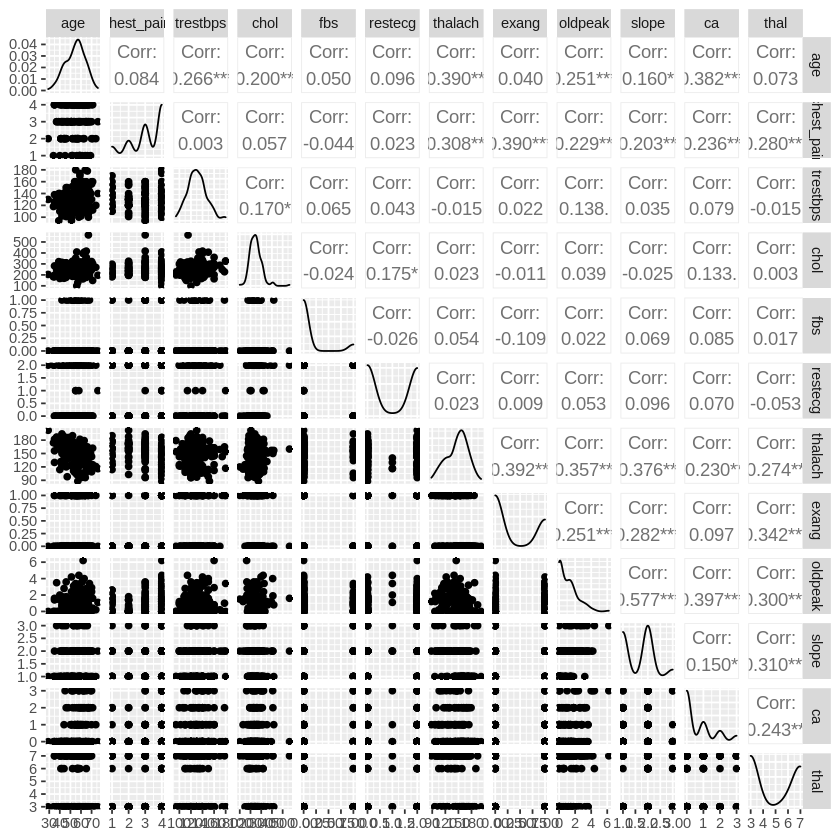

In [50]:
set.seed(2000)

#Split the data into a training and testing set for analysis
heart_split <- initial_split(heart_disease_data, prop = 0.60, strata = age)
heart_testing <- testing(heart_split)
heart_training <- training(heart_split)

#To visualize the predictor variables:
heart_eda <- heart_training %>%
             ggpairs(columns = 1:12, alpha = 0.05) %>%
             suppressWarnings()

heart_eda

In [51]:
set.seed(2000)

lm_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

heart_recipe <- recipe(age ~ chest_pain + trestbps+chol + 
               fbs + restecg + thalach + exang + oldpeak 
               + slope + ca + thal, data = heart_training) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

In [52]:
set.seed(2000)


heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(lm_spec) %>%
    fit(data = heart_training)

In [53]:
set.seed(2000)


lm_rmse <- heart_fit %>%
        predict(heart_training) %>%
        bind_cols(heart_training) %>%
        metrics(truth = age, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

In [54]:
set.seed(2000)


lm_rmspe <- heart_fit %>%
        predict(heart_testing) %>%
        bind_cols(heart_testing) %>%
        metrics(truth = age, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

lm_rmspe

[1] 7.645737

In [81]:
#OPTION B:

heart_disease_data_B <- rbind(van_data_csv,cleveland_data_csv,hungary_data_csv, switzerland_data_csv) %>%
                select(age, trestbps, thalach, ca, oldpeak ) %>%
                mutate_all(as.numeric) %>% 
                filter(age != "?") %>%
                filter(thalach != "?")%>%
                filter(oldpeak != "?") %>%
                filter(ca != "?") %>%
                filter(trestbps != "?")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


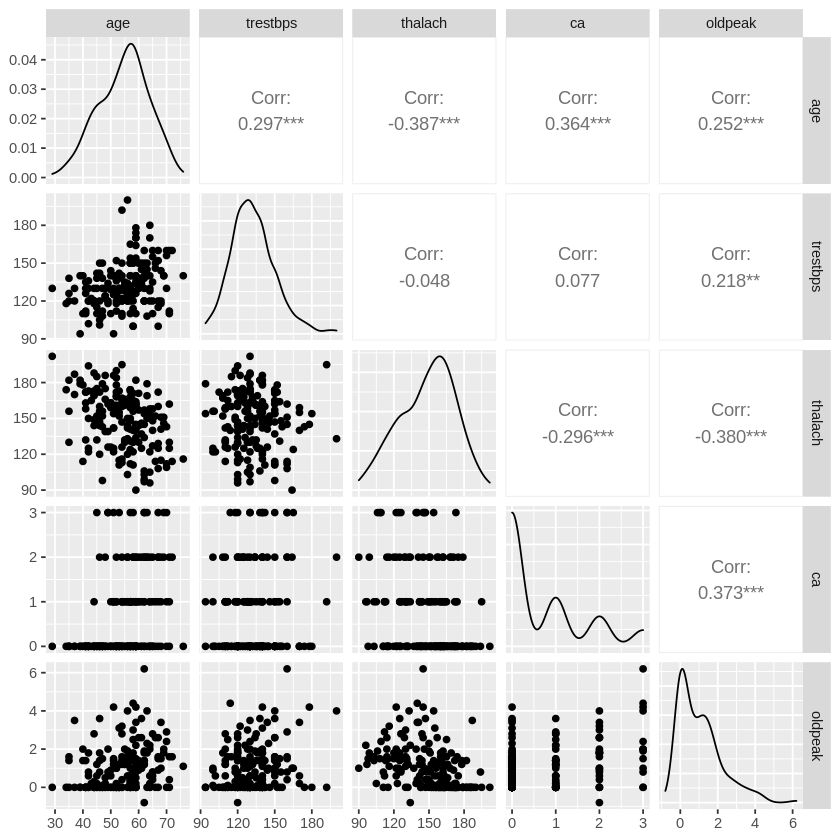

In [83]:
set.seed(2000)
#Split the data into a training and testing set for analysis
heart_split_B <- initial_split(heart_disease_data_B, prop = 0.60, strata = age)
heart_testing_B <- testing(heart_split_B)
heart_training_B <- training(heart_split_B)

#To visualize the predictor variables:
heart_eda <- heart_training_B %>%
             ggpairs(columns = 1:5, alpha = 0.05) %>%
             suppressWarnings()

heart_eda

In [114]:
set.seed(2000)

lm_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

heart_recipe_B <- recipe(age ~., data = heart_training_B) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

In [119]:
set.seed(2000)
heart_fit_B <- workflow() %>%
    add_recipe(heart_recipe_B) %>%
    add_model(lm_spec) %>%
    fit(data = heart_training_B)

lm_rmse <- heart_fit_B %>%
        predict(heart_training_B) %>%
        bind_cols(heart_training_B) %>%
        metrics(truth = age, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

lm_rmspe <- heart_fit_B %>%
        predict(heart_testing_B) %>%
        bind_cols(heart_testing_B) %>%
        metrics(truth = age, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

lm_rmspe

[1] 7.458904

In [131]:
#OPTION C:
set.seed(2000)

# Find best K value
heart_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("regression") 

heart_recipe_2 <- heart_recipe_B %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

heart_vfold <- vfold_cv(heart_training_B, v = 5, strata = age)

heart_workflow_2 <- workflow() %>%
  add_recipe(heart_recipe_2) %>%
  add_model(heart_spec_2)

gridvals <- tibble(neighbors = seq(from = 1, to = 20))

heart_results <- heart_workflow_2 %>%
  tune_grid(resamples = heart_vfold, grid = gridvals) %>%
  collect_metrics() 

k_min <- heart_results %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1) %>%
   select(neighbors) %>%
   pull()

# Find RMSPE using best K value
heart_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

heart_best_fit <- workflow() %>%
         add_recipe(heart_recipe_2) %>%
         add_model(heart_best_spec) %>%
         fit(data = heart_training_B)

knn_rmspe <- heart_best_fit %>%
          predict(heart_testing_B) %>%
          bind_cols(heart_testing_B) %>%
          metrics(truth = age, estimate = .pred) %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()

knn_rmspe

[1] 7.703921